In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

In [2]:
data = pd.read_csv('https://query.data.world/s/2jrkoyzkutqavbjqawv636ry3ibenw')

In [3]:
data = data.drop(["recordID","customer_id"], axis=1)

In [4]:
data

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,HI,101,510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,MT,137,510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,OH,103,408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,NM,99,415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,SC,108,415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12887,MT,25,415,no,no,0,134.3,98,22.83,202.3,109,17.20,195.9,100,8.82,12.6,5,3.40,2,no
12888,MT,113,415,no,no,0,215.9,93,36.70,240.1,85,20.41,156.7,123,7.05,4.9,5,1.32,3,no
12889,ID,88,415,no,yes,31,181.6,91,30.87,213.2,120,18.12,207.8,104,9.35,11.4,4,3.08,1,no
12890,AK,120,415,no,no,0,178.4,97,30.33,168.3,113,14.31,120.5,93,5.42,9.3,9,2.51,1,no


In [5]:
#check missing data, copied from week 4 page 5
numberMissing = data.isna().sum()
numberMissing[numberMissing > 0]

Series([], dtype: int64)

In [6]:
#split data into features and targets
features = data.drop(["churn"], axis=1)
target = data["churn"]

In [7]:
#split data into 3 portions copied from week 4 page 5
X_main, X_test, y_main, y_test = train_test_split(features, target, test_size=0.2, random_state=711)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=54)
X_train.shape, X_val.shape, X_test.shape

((7734, 19), (2579, 19), (2579, 19))

In [8]:
# data preprocessing adapted from p7 week 4
catVars =  ["state", "area_code", "international_plan",
    "voice_mail_plan"]

ct = make_column_transformer(
  (OneHotEncoder(handle_unknown="ignore"), catVars),
  remainder= StandardScaler()
)

X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.transform(X_val)
X_test_ct = ct.transform(X_test)

In [9]:
#ordinal encoder for target
oe = OrdinalEncoder()
y_train_oe = oe.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_oe = oe.transform(y_test.to_numpy().reshape(-1,1))
y_val_oe = oe.transform(y_val.to_numpy().reshape(-1,1))

In [10]:
#model 1: a feedforward model
def create_modelff(seed=5097536):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(InputLayer(input_shape=X_train_ct.shape[1:], name='input_layer'))
    model.add(Dense(128, "leaky_relu",name="hidden1"))
    model.add(Dense(32, "leaky_relu",name="hidden2"))
    model.add(Dense(1, "sigmoid",name="output"))
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 128)               9472      
                                                                 
 hidden2 (Dense)             (None, 32)                4128      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 13,633
Trainable params: 13,633
Non-trainable params: 0
_________________________________________________________________


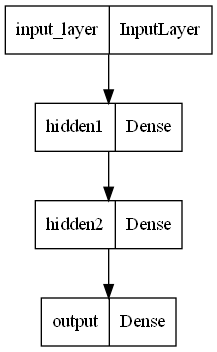

In [11]:
modelff = create_modelff()
modelff.summary()
plot_model(modelff)

In [12]:
#train model 1
pr_auc = tf.keras.metrics.AUC(curve="PR", name="pr_auc")
modelff.compile(optimizer="adam", loss="BinaryCrossentropy", metrics=["accuracy", "AUC", pr_auc])
esff = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_pr_auc", verbose=1)
%time histff=modelff.fit(X_train_ct, y_train_oe, callbacks=[esff], epochs=1_000, verbose=0, validation_data=(X_val_ct, y_val_oe), class_weight={0: 1, 1: 10})

C:\Users\yuhow\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/hidden1/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/hidden1/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/hidden1/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping
CPU times: total: 1min 20s
Wall time: 36.3 s


In [13]:
modelff.evaluate(X_train_ct, y_train_oe, verbose=0)

[0.005078264512121677,
 0.9997413754463196,
 0.9999995827674866,
 0.9999974370002747]

In [14]:
modelff.evaluate(X_val_ct, y_val_oe, verbose=0)

[0.09838380664587021,
 0.9810003638267517,
 0.9791858792304993,
 0.9603365659713745]

In [15]:
y_pred = modelff.predict(X_test_ct)

81/81 [==============================] - 0s 848us/step


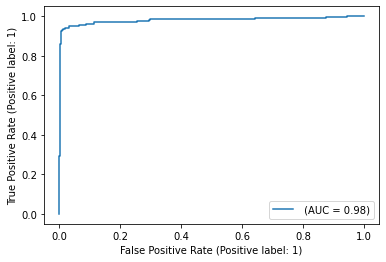

In [16]:
RocCurveDisplay.from_predictions(y_test_oe, y_pred, name="");

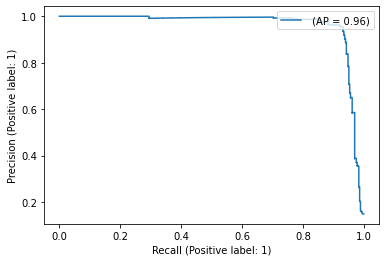

In [17]:
PrecisionRecallDisplay.from_predictions(y_test_oe, y_pred, name=""); plt.legend(loc="upper right");

In [18]:
#data preprocess for model 2
NUM_STATES, NUM_AREA = X_train.nunique()[["state", "area_code"]]

ctwd = make_column_transformer(
  (OrdinalEncoder(), ["state", "area_code", "international_plan",
    "voice_mail_plan"]),
  remainder=StandardScaler()
)
X_train_ctwd = ctwd.fit_transform(X_train)
X_test_ctwd = ctwd.transform(X_test)
X_val_ctwd = ctwd.transform(X_val)

In [19]:
#extract categorical data for entity embedding
X_train_state = X_train_ctwd[:,0]
X_test_state = X_test_ctwd[:,0]
X_val_state = X_val_ctwd[:,0]
X_train_area = X_train_ctwd[:,1]
X_val_area = X_val_ctwd[:,1]
X_test_area = X_test_ctwd[:,1]
X_train_rest = X_train_ctwd[:,2:]
X_test_rest = X_test_ctwd[:,2:]
X_val_rest = X_val_ctwd[:,2:]

In [20]:
#inputs for model 2
usstates = Input(shape=(1,), name="states")
area = Input(shape=(1,), name="area_code")
otherInputs = Input(shape=X_train_rest.shape[1:], name="otherInputs")

In [21]:
#Create embeddings and join them with the other inputs week 4 p32
tf.random.set_seed(21072022)
stateEE = Embedding(input_dim=NUM_STATES, output_dim=2,
    name="stateEE")(usstates)
stateEE = Reshape(target_shape=(2,))(stateEE)

areaEE = Embedding(input_dim=NUM_AREA, output_dim=2,
    name="area_codeEE")(area)
areaEE = Reshape(target_shape=(2,))(areaEE)

x = Concatenate(name="wide")([stateEE, areaEE, otherInputs])

In [22]:
#building model 2 with function API
hidden1 = Dense(64, activation="leaky_relu", name="hidden1")(x)
hidden2 = Dense(64, activation="leaky_relu", name="hidden2")(hidden1)
hidden3 = Dense(8, activation="leaky_relu", name="deep")(hidden2)
concat = Concatenate(name="wide-and-deep")([x, hidden3])
output = Dense(1,activation="sigmoid", name="output")(concat)
modelwd = Model(inputs=[usstates,area,otherInputs], outputs=[output])

In [23]:
plot_model(modelwd,show_shapes=True)
modelwd.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 states (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 area_code (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 stateEE (Embedding)            (None, 1, 2)         102         ['states[0][0]']                 
                                                                                                  
 area_codeEE (Embedding)        (None, 1, 2)         6           ['area_code[0][0]']              
                                                                                              

In [24]:
modelwd.compile(optimizer="sgd", loss="BinaryCrossentropy", metrics=["accuracy", "AUC", pr_auc])
eswd = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_pr_auc", verbose=1)
%time histff=modelwd.fit((X_train_state,X_train_area,X_train_rest), y_train_oe, callbacks=[eswd], epochs=1_000, verbose=0, validation_data=((X_val_state,X_val_area,X_val_rest), y_val_oe), class_weight={0: 1, 1: 10})

Restoring model weights from the end of the best epoch: 111.
Epoch 161: early stopping
CPU times: total: 1min 25s
Wall time: 52.8 s


In [25]:
modelwd.evaluate((X_train_state,X_train_area,X_train_rest), y_train_oe, verbose=0)

[0.006703645456582308,
 0.9990949034690857,
 0.9999755620956421,
 0.9998401999473572]

In [26]:
modelwd.evaluate((X_val_state,X_val_area,X_val_rest), y_val_oe, verbose=0)

[0.08396697044372559,
 0.9821636080741882,
 0.984690248966217,
 0.9613032341003418]

In [27]:
y_predwd = modelwd.predict((X_test_state,X_test_area,X_test_rest))

81/81 [==============================] - 0s 723us/step


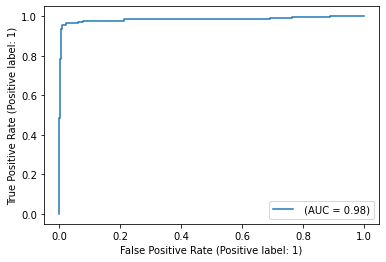

In [28]:
RocCurveDisplay.from_predictions(y_test_oe, y_predwd, name="");
plt.savefig('roc.png')

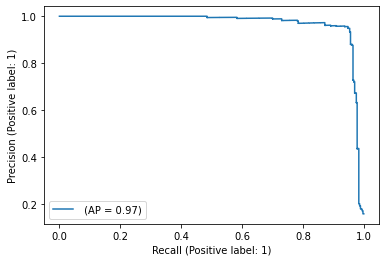

In [29]:
PrecisionRecallDisplay.from_predictions(y_test_oe, y_predwd, name="");
plt.savefig('pr.png')

In [30]:
modelwd.evaluate((X_test_state,X_test_area,X_test_rest), y_test_oe, verbose=0)

[0.08886951953172684,
 0.9856533408164978,
 0.9846564531326294,
 0.9592158794403076]

In [31]:
#baseline model performance binary cross entropy
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
y_base=[0.14]*2579
bce(y_val_oe, np.array(y_base).reshape(-1,1)).numpy()

0.41547915290708254

In [32]:
#baseline model performance binary accracy
bacc=tf.keras.metrics.BinaryAccuracy()
y_base=[0]*2579
bacc.update_state(y_val_oe, np.array(y_base).reshape(-1,1))
bacc.result().numpy()

0.85420704

In [33]:
#baseline model performance accuracy
y_base=[0.]*2579
sklearn.metrics.accuracy_score(y_val_oe,np.array(y_base).reshape(-1,1))

0.8542070569988368

In [34]:
#baseline model performance AUC ROC
y_base=[0.]*2579
sklearn.metrics.roc_auc_score(y_val_oe,np.array(y_base).reshape(-1,1))

0.5

In [35]:
#baseline model performance AUC ROC method 2
broc=tf.keras.metrics.AUC(curve="ROC")
broc.update_state(y_val_oe, np.array(y_base).reshape(-1,1))
broc.result().numpy()

0.5

In [36]:
#baseline model performance AUC PR 
bpr=tf.keras.metrics.AUC(curve="PR")
bpr.update_state(y_val_oe, np.array(y_base).reshape(-1,1))
bpr.result().numpy()

0.14579295

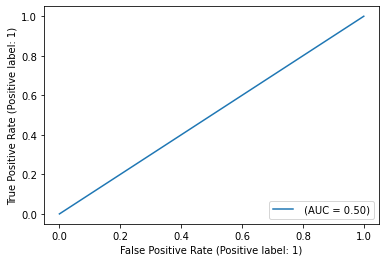

In [37]:
RocCurveDisplay.from_predictions(y_val_oe, y_base, name="");
plt.savefig('baseroc.png')

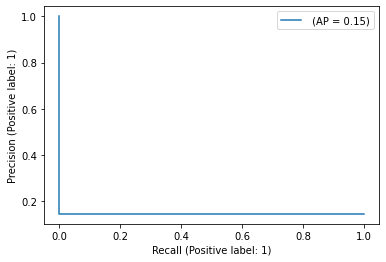

In [38]:
PrecisionRecallDisplay.from_predictions(y_val_oe, y_base, name=""); plt.legend(loc="upper right");
plt.savefig('basepr.png')

In [39]:
#confusion matrix
confusion_matrix(y_val_oe, y_base)

array([[2203,    0],
       [ 376,    0]], dtype=int64)